In [ ]:
# Log_returns = LN (1 + Reg_Returns)
# Reg_Returns = EXP(Log_Returns) -1

In [1]:
#Technical analysis library - built on pnadas and numpy
! pip install ta
from ta.trend import SMAIndicator

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29413 sha256=85c11b2b868455f8b32d6e1c87beca7896a1f27c1593efdfef6303120a078556
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [2]:
import numpy as np
import yfinance as yf
import pandas as pd
import pandas_datareader as pdr
# Ignore printing all warnings.
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [4]:
tickers = ['AAPL','^GSPC']

start_date = '2021-01-01'
end_date = '2021-12-31'

# Collect the historical stock prices data from Yahoo Finance into a DataFrame.
#Set progress = False, if font want to seee progress of download
data = yf.download(tickers, start=start_date, end=end_date)

#Store only the close prices
df = data['Close']

# Rename the ^GSPC column to SP_500.
df.rename(columns={'^GSPC':'SP500'}, inplace=True)

df.head()

[*********************100%%**********************]  2 of 2 completed


Ticker,AAPL,SP500
Date,,
2021-01-04,129.410004,3700.649902
2021-01-05,131.009995,3726.860107
2021-01-06,126.599998,3748.139893
2021-01-07,130.919998,3803.790039
2021-01-08,132.050003,3824.679932


**MA Crossover strategy:**

---



Long term / Slow
Short Term / Fast

Rules --> Variables --> Parameters

Rule --> Short Term Moving average Crosses a Long term Moving average
Variables --> Short MA / Long MA
Parameters --> 5 and 21


In [5]:
# To plot a crossover of 5 Vs 21 days
ST_Window = 5
LT_Window = 21

# You can also make Moving averages by .rolling(window).mean(), but we are using a library.
# Initialize SMAIndicator  and store the feature in a STMA and LTMA
indicator_1 = SMAIndicator(close = df["AAPL"], window= ST_Window, fillna= False)
STMA = indicator_1.sma_indicator()

indicator_2 = SMAIndicator(close = df["AAPL"], window= LT_Window, fillna= False)
LTMA = indicator_2.sma_indicator()

In [6]:
'''
To backtest and add visualisations of the signals,
We will prepare a dataframe for storing all important variables.
This will help for further calc and visulaisation
'''
bt_data = pd.DataFrame()
bt_data["Stock_Price"] = df["AAPL"]
bt_data['Benchmark_Price'] = df['SP500']
bt_data["STMA"] = STMA
bt_data["LTMA"] = LTMA

# Note that you will lose n days of data due to MA
# Dropping all NA
bt_data = bt_data.dropna()

#print the data
bt_data.head()

,Stock_Price,Benchmark_Price,STMA,LTMA
Date,,,,
2021-02-02,134.990005,3826.310059,136.048001,133.182381
2021-02-03,133.940002,3830.169922,134.424002,133.398096
2021-02-04,137.389999,3871.739990,134.484003,133.701905
2021-02-05,136.759995,3886.830078,135.444000,134.185715
2021-02-08,136.910004,3915.590088,135.998001,134.470953


In [7]:
# Store in column "Position" whenever bullish (+1) or bearish (-1) conditions
bt_data["Position"] = np.where(bt_data['STMA'] > bt_data['LTMA'], 1.0, -1.0)

# Print the data
bt_data.head()

,Stock_Price,Benchmark_Price,STMA,LTMA,Position
Date,,,,,
2021-02-02,134.990005,3826.310059,136.048001,133.182381,1.0
2021-02-03,133.940002,3830.169922,134.424002,133.398096,1.0
2021-02-04,137.389999,3871.739990,134.484003,133.701905,1.0
2021-02-05,136.759995,3886.830078,135.444000,134.185715,1.0
2021-02-08,136.910004,3915.590088,135.998001,134.470953,1.0


Calculating the Returns of Stock, Strategy and Benchmark

In [8]:
# Here we will use log returns as they are additive.
# Adding all the daily log returns will give us the overall returns which we can later convert back to regular.
# Log returns are normally distributed and we can perform calculations.

# Storing the Log returns by converting the Regular returns
# Log_returns = LN (1 + Reg_Returns)

reg_returns = bt_data['Stock_Price'].pct_change()

bt_data['Stock_Returns'] = np.log ( 1 + reg_returns)

# Similarly, Storing the benchmark returns as it will be used later for other financial metrics
bt_data['Benchmark_Returns'] = np.log ( 1 + bt_data['Benchmark_Price'].pct_change())

In [9]:
# We can multiply todays returns with yesterdays poaition.
# This is because we  get the returns today based on our previous position.
# Storing the strategy returns in the bt_data

bt_data["Strategy_Returns"] = bt_data["Stock_Returns"] * bt_data["Position"].shift(1)

# Print the data
bt_data.head()

,Stock_Price,Benchmark_Price,STMA,LTMA,Position,Stock_Returns,Benchmark_Returns,Strategy_Returns
Date,,,,,,,,
2021-02-02,134.990005,3826.310059,136.048001,133.182381,1.0,NaN,NaN,NaN
2021-02-03,133.940002,3830.169922,134.424002,133.398096,1.0,-0.007809,0.001008,-0.007809
2021-02-04,137.389999,3871.739990,134.484003,133.701905,1.0,0.025432,0.010795,0.025432
2021-02-05,136.759995,3886.830078,135.444000,134.185715,1.0,-0.004596,0.003890,-0.004596
2021-02-08,136.910004,3915.590088,135.998001,134.470953,1.0,0.001096,0.007372,0.001096


<Axes: xlabel='Date'>

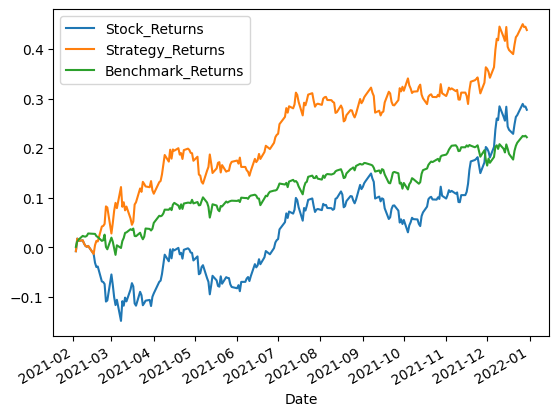

In [10]:
# We can visulaise the performance over time with cumsum
# Comparing the stock returns and the strategy returns
# Cumsum Returns the cumulative sum of the elements along a given axis

bt_data[["Stock_Returns", "Strategy_Returns", "Benchmark_Returns"]].cumsum().plot()

In [11]:
'''
Annualised risk return performance metrics
1.Annualised returns
2.Annualised Risk or standard deviation
3.Sharpe Ratio
'''
# 1.  Annual Mean Returns or Expected returns
annual_ret = bt_data[["Stock_Returns", "Strategy_Returns", "Benchmark_Returns"]].mean() * 252
# Convert back to regular returns
annual_regular_ret = np.exp(annual_ret)-1
print('Annual regular returns are: \n',annual_regular_ret)

#2. Annual Standard deviation
# Covert each log returns to regular and then take standard deviation
annual_regular_std = (np.exp(bt_data[["Stock_Returns", "Strategy_Returns", "Benchmark_Returns"]])-1).std() * (252 **0.5)
print('Annual regular std is: \n', annual_regular_std) # Note that these are the log returns

#3. Sharpe Ratio
# Since we have already calculated the annual returns and risk we can use them
sr = annual_regular_ret/ annual_regular_std
print("The Sharpe Ratio is : \n ", sr)

#The strategy performs much better than just investing in the stock

Annual regular returns are: 
 Stock_Returns        0.355634
Strategy_Returns     0.617125
Benchmark_Returns    0.275751
dtype: float64
Annual regular std is: 
 Stock_Returns        0.239086
Strategy_Returns     0.237966
Benchmark_Returns    0.126624
dtype: float64
The Sharpe Ratio is : 
  Stock_Returns        1.487471
Strategy_Returns     2.593328
Benchmark_Returns    2.177711
dtype: float64


#Part 2 : With more Ratios

### Drawdown and Calmar Ratio

The max drawdown is 0.07617453069817508


<Axes: xlabel='Date'>

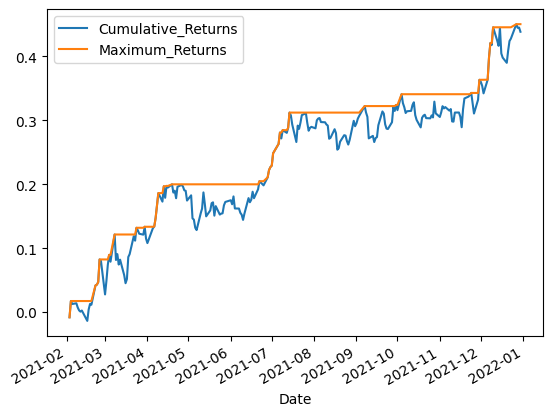

In [12]:
# Cumsum returns the cummulative of a series
bt_data["Cumulative_Returns"] = bt_data["Strategy_Returns"].cumsum()

# Cummax always returns the Maximum of the the cumulative
bt_data["Maximum_Returns"] = bt_data["Cumulative_Returns"].cummax()

# Store the differences in a new colum "drawdowns"
# Note that we are calculating the drawdowns from cumsum of returns which is already in percentage.
bt_data["drawdowns"] = bt_data["Maximum_Returns"] - bt_data["Cumulative_Returns"]

# The maximum difference is refered as "Drawdown"
max_drawdown = bt_data["drawdowns"].max()
print("The max drawdown is", max_drawdown)

#Visualise how these two look like
bt_data[["Cumulative_Returns", "Maximum_Returns"]].dropna().plot()

In [15]:
annual_regular_ret

Stock_Returns        0.355634
Strategy_Returns     0.617125
Benchmark_Returns    0.275751
dtype: float64

In [16]:
# We have already stored all the annualised risk return metrics for the stock[0] and strategy[1]
Calmar_ratio = annual_regular_ret[1] / max_drawdown

Calmar_ratio

8.101464020347038

### Tracking Error and Information Ratio

In [17]:
# Storing the difference of stock returns and benchmark returns
bt_data["Strategy-Benchmark"] = bt_data['Strategy_Returns'] - bt_data['Benchmark_Returns']

#average of difference
average_of_difference = bt_data["Strategy-Benchmark"].mean()

#standard deviation of the difference. This std dev is also known as Tracking error. The lower the better
std_dev_of_difference = bt_data["Strategy-Benchmark"].std()

#Information Ratio daily
IR_daily =  average_of_difference / std_dev_of_difference

#Covert to annual
IR_annual = IR_daily * (252**0.5)

IR_annual

0.8750519053752719

### Treynor Ratio

In [18]:
#Similar to what we did in the  BASS notebook. Prepare a covariance matrix
matrix = bt_data[['Strategy_Returns', 'Benchmark_Returns']].cov()

#Beta = Cov( Strategy, banchmark) / Var (benchmark)
Beta = matrix.iat[0,1] / matrix.iat[1,1]

Treynor_ratio = annual_regular_ret[1] / Beta

Treynor_ratio


-22.860588822895195

### Sortino Ratio

In [19]:
# Create a new series with positive returns converted to 0 and negative returns as it is
converted_returns = bt_data['Strategy_Returns'].apply(lambda x: 0 if x > 0 else x)
converted_reg_returns = np.exp(converted_returns)-1

squared_converted_returns = converted_reg_returns ** 2

squared_sum = np.sum(squared_converted_returns)
len_squared_sum = len(converted_returns)

downside_deviation = np.sqrt(squared_sum/len_squared_sum)

#Calculate annualised downside dev
annual_converted_sd = downside_deviation * np.sqrt(252)

#Calculate Sortino
sortino = annual_regular_ret[1] / annual_converted_sd

sortino
print("The sortino ratio is", sortino)
print("The sortino ratio is {}".format(sortino))
print("The sortino ratio is {:.1f}".format(sortino))
print("The sortino ratio is {:.2f}".format(sortino))

The sortino ratio is 4.1199773961979265
The sortino ratio is 4.1199773961979265
The sortino ratio is 4.1
The sortino ratio is 4.12


In [20]:
Long_Days = len(bt_data[bt_data.Position == 1.0])
Short_Days = len(bt_data[bt_data.Position == -1.0])
No_Trading_Days = len(bt_data[bt_data.Position == 0])

Long_Days, Short_Days, No_Trading_Days

(148, 83, 0)

This notebook is to make you understand the logic of Vectorised backtesting.
We can make functions for different calculations and make a strategy class.
By doing that, we can use the backtester for any instrument and any period by just pressing a run button.